In [15]:
# Generic imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Definitions
---
    1. Local pixels: All pixels inside an ocountour
    2. Inner pixels: All pixels inside an icountour
    3. Sandwich pixels: Pixels inside ocountour but not inside icountour
    
### Objective
---
    In this task, we want to investigate if thresholding the pixel values can give us a good way to segment inner pixels, given local pixels.
    
To do this, our approach is to compare the distributions (histograms) of the innner and sandwich pixels.

#### Data collection

First, we implement a helper function (using methods from reading.py) to get all datapoints from disk. Then, we implement another function to iterate over these datapoints and collect all inner and sandwich pixels. Please ignore the normalization part for now.

In [16]:
import reading

def get_all_datapoints():
    """Read all datapoints from disk"""
    link_filepath = './final_data/link.csv'
    patients = reading.get_patients(link_filepath)

    all_datapoints = []
    for patient in patients:
        datapoints = reading.get_datapoints(patient)
        all_datapoints.extend(datapoints)
        
    return all_datapoints


def get_pixels(all_datapoints, normalization):
    """Function to collect inner and sandwich pixels from all datapoints.

    :param all_datapoints: List of reading.Datapoint objects
    :param normalization: One of {'none', 'full', 'local'}
    
    :return: all innner pixels
    :return: all sandwich pixels
    """
    
    all_inner_pixels = []
    all_sandwich_pixels = []
    for datapoint in all_datapoints:
        dicom = datapoint.dicom
        if normalization == 'none':
            pass
        elif normalization == 'full':
            image_mean = np.mean(datapoint.dicom)
            image_std = np.std(datapoint.dicom)
            dicom = (dicom - image_mean) / image_std       
        elif normalization == 'local':
            local_mean = np.mean(dicom[datapoint.omask])
            local_std = np.std(dicom[datapoint.omask])
            dicom = (dicom - local_mean) / local_std   
        else:
            raise NotImplementedError
            
        inner_pixels = dicom[datapoint.imask]
        all_inner_pixels.extend(inner_pixels)
        sandwich_mask = datapoint.omask ^ datapoint.imask  # xor finds sandwich
        sandwich_pixels = dicom[sandwich_mask]
        all_sandwich_pixels.extend(sandwich_pixels)

    # print len(all_inner_pixels)
    # print len(all_sandwich_pixels)
    return all_inner_pixels, all_sandwich_pixels

#### Plotting
Now that we can collect the values, let's define a function to plot a histograms of the pixel intensities. This will tell us roughly how separable these two distributions are.

In [13]:
def hist_plot(pixel_labels, num_bins):
    """Function for histogram plot.

    :param pixel_labels: List of (pixels, label) where
        pixels is a list of pixel values
        label is a string
        
    :param num_bins: int denoting number of bins for histogram
    """
    for pixels, label in pixel_labels:
        plt.hist(pixels, num_bins, label=label, alpha=0.5)

Let us now try to use these functions and get the histogram plot

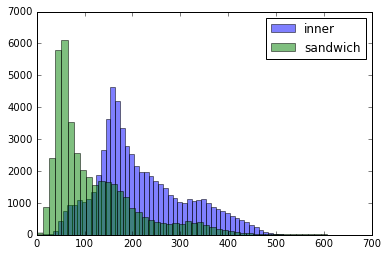

In [14]:
all_datapoints = get_all_datapoints()
num_bins = 50
normalization = 'none'
inner_pixels, sandwich_pixels = get_pixels(all_datapoints, normalization)
plt.figure()
pixel_labels = [(inner_pixels, 'inner'),
                (sandwich_pixels, 'sandwich')]
hist_plot(pixel_labels, num_bins)
plt.legend()
plt.show()

This shows a lot of overlap between the two distributions. But they do have some non-trivial separation. But how do we know if this is good? To quantify the separation, we can try to find the best threshold, i.e. the one that gives the best accuracy using only thresholding.

So, we implement a function that computes the best threshold and the best accuracy in thresholding.py. A test for this function is provided in thresholding_test.py

Now using this function, we can see how well we are doing:

In [18]:
import thresholding

thresh, acc = thresholding.find_best_threshold(sandwich_pixels, inner_pixels)
print 'Accuracy = {:04.2f} %'.format(acc*100)

Accuracy = 77.86 %


So, the accuracy is not very good. We now explore some approaches that may be useful for imporoving the separation between the distributions.

We see a second smaller bump in both distributions suggesting that the distribution is multimodal. One potential reason for that is the following: all dicom images may not have the same pixel intensity characteristics. For example, some images may be overexposed, so that the mean pixel value is very different. Another reason can be that the contrast (as measured by standard deviation) does not match. We can plot histograms of these two quantities across the images to check if this hypothesis is true:

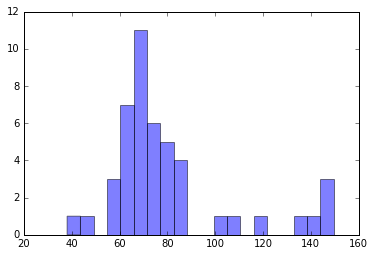

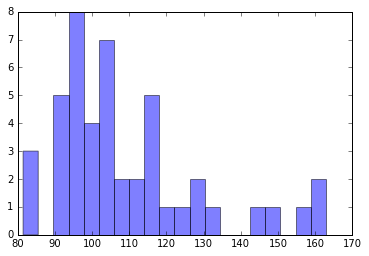

In [21]:
all_datapoints = get_all_datapoints()
num_bins = 50
normalization = 'none'

all_means = []
all_stds = []
for datapoint in all_datapoints:
    mean = np.mean(datapoint.dicom)
    std = np.std(datapoint.dicom)
    all_means.append(mean)
    all_stds.append(std)
    
num_bins = 20
plt.figure()
pixel_labels = [(all_means, 'mean')]
hist_plot(pixel_labels, num_bins)
plt.show()

num_bins = 20
plt.figure()
pixel_labels = [(all_stds, 'std')]
hist_plot(pixel_labels, num_bins)

As we can see, the mean value for one image can be as large as thrice some other images. Similarly the standard deviation has a 2x variation. This suggests that perhaps normalizing the entire image by first subtracting the mean and then dividing by the standard deviation can potentially improve the distributional separation. We test this now:

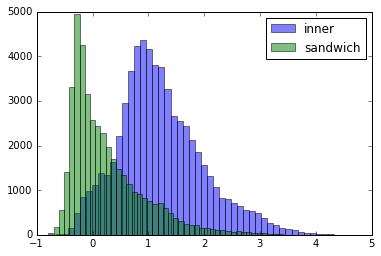

In [27]:
all_datapoints = get_all_datapoints()
num_bins = 50
normalization = 'full'
inner_pixels, sandwich_pixels = get_pixels(all_datapoints, normalization)
plt.figure()
pixel_labels = [(inner_pixels, 'inner'),
                (sandwich_pixels, 'sandwich')]
hist_plot(pixel_labels, num_bins)
plt.legend()
plt.show()

Visually, these distributions look much better than the previous one. The smaller bump is now gone suggesting that we have largely accounted for the multimodality. Let's check how well we do on the accuracy:

In [28]:
thresh, acc = thresholding.find_best_threshold(sandwich_pixels, inner_pixels)
print 'Accuracy = {:04.2f} %'.format(acc*100)

Accuracy = 80.31 %


This is an improvement of about 2.5%. Taking the same idea further, it may be possible that certain regions of the image recieve different kinds of illumination or have different contrast. Thus, instead of considering the full image, we can consider only the local pixels to estimate the mean and the variance and use that for normalization. We now compute the distribtuons under this normalization and the accuracy:

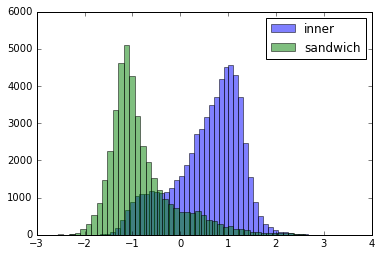

Accuracy = 84.16 %


In [30]:
all_datapoints = get_all_datapoints()
num_bins = 50
normalization = 'local'
inner_pixels, sandwich_pixels = get_pixels(all_datapoints, normalization)
plt.figure()
pixel_labels = [(inner_pixels, 'inner'),
                (sandwich_pixels, 'sandwich')]
hist_plot(pixel_labels, num_bins)
plt.legend()
plt.show()

thresh, acc = thresholding.find_best_threshold(sandwich_pixels, inner_pixels)
print 'Accuracy = {:04.2f} %'.format(acc*100)

This gives us about 4% improvement in the accuracy! The distributions again seem to have become multimodal revealing that there might be even better ways to cluster or normalize the distributions

### Other methods
---
Here we did an independent decision for each pixel. But we also know thier locations, so we could use that to make a more spatially consistent decision.

A possible approach is to define a similarity metric between adjacent pixels based on their values. This can then be used as a weight in a graph where nodes are pixels and adjacent pixels are neighbors. Then we can compute the min-cut to approximate the separation between the inner and sandwich pixels.


### Conclusion
---

We explored if we can do simple thresholding on pixel values to segment inner pixels from sandwich pixels. Our approach was to compute histograms of the two distributions and find the optimal threshold. We also explored a few simple normalization schemes which gave us about 6.5% improvement. Our best model achieves 84.16% accuracy, which is surprisingly high for such a simple algorithm. Finally, discussed a potential algorithm based on min-cut.